<a href="https://colab.research.google.com/github/TejoramV/cs6910_assignment1/blob/main/Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>




# CS6910 Assignment-1

by
- Akansh Maurya (CS22Z003)
- Tejoram Vivekanandan (EE22Z001)

In [4]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
!pip install wandb
!wandb login
import wandb
wandb.init(project="CS6910-Assignment-1", entity="tejoram")

     |████████████████████████████████| 1.7 MB 5.3 MB/s 
     |████████████████████████████████| 181 kB 45.0 MB/s 
     |████████████████████████████████| 144 kB 58.6 MB/s 
     |████████████████████████████████| 63 kB 2.1 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=1223fc971ac2beb9c5bbac8aae83ae5ba9b79a9998e9e109377c92a5ec9a6af3
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built pathtools
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


wandb: Currently logged in as: tejoram (use `wandb login --relogin` to force relogin)


### Question 1: Loading and ploting the dataset

In [5]:
from keras.datasets import fashion_mnist
from sklearn.model_selection import train_test_split
import pandas as pd
dataset= fashion_mnist.load_data()
(X_train_and_validation, y_train_and_validation), (X_test, y_test) = dataset
X_train, X_validation, y_train, y_validation = train_test_split(X_train_and_validation, y_train_and_validation, test_size=0.1, random_state=42)
X_train = (X_train/255.0).astype(np.float32)
X_validation = (X_validation/255.0).astype(np.float32)
X_test = (X_test/255.0).astype(np.float32)

In [6]:
labels_dict =  {0:	"T-shirt/top",
1 :"Trouser",
2 :"Pullover",
3:	"Dress",
4 :"Coat",
5 :"Sandal",
6 :"Shirt",
7 :"Sneaker",
8 :"Bag",
9 :"Ankle boot"}

In [7]:
print("Train Dataset Shape: ", X_train.shape)
print("Train Target Vector Shape: ", y_train.shape) 
print("Test Dataset Shape:", X_test.shape)
print("Test Target Vector Shape", y_test.shape)
print("Validation Dataset Shape:", X_validation.shape)
print("Validation Target Vector Shape", y_validation.shape)

Train Dataset Shape:  (54000, 28, 28)
Train Target Vector Shape:  (54000,)
Test Dataset Shape: (10000, 28, 28)
Test Target Vector Shape (10000,)
Validation Dataset Shape: (6000, 28, 28)
Validation Target Vector Shape (6000,)


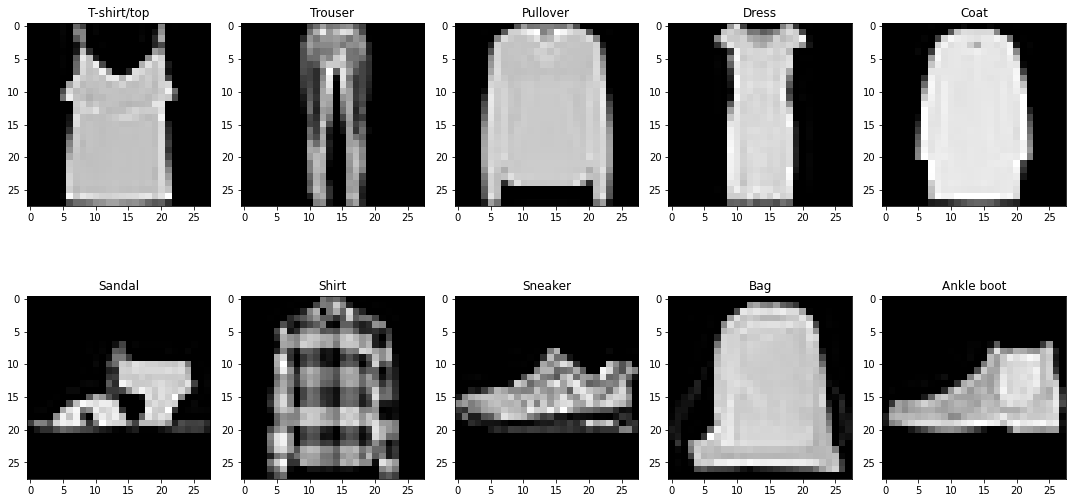

In [8]:
wandb.init(project="CS6910-Assignment-1", entity="tejoram")
sorted_arr = [-1] * 10
step_count=0
steps_needed=5                                  ###increase the step as per the need, currently it is restricted to 5 for better user iterface
while(step_count<steps_needed):
  for x in range(10):
    boolean = 0
    sample = sorted_arr[x]+1
    while(boolean == 0):
      if x == y_train[sample]:
        boolean = 1
        sorted_arr[x]=sample
      sample=sample+1
  step_count= step_count+1  
  %matplotlib inline
  fig, axes = plt.subplots(2,5, figsize = (15,8))
  for i in range(10):
     ax = axes[i//5, i%5]
     x=sorted_arr[i]
     ax.imshow(X_train[x], cmap='gray')
     ax.set_title(f'{labels_dict[y_train[x]]}')
  plt.tight_layout()

  wandb.log({"Data-plot": fig})
wandb.finish()

**Implement a feedforward and backpropagation**

In [9]:
from tqdm.auto import tqdm

In [10]:
class DeepNeuralNetwork():
  def __init__(self,epochs,num_input_nodes, hidden_layers,num_output_nodes, lr, weight_decay, optimizer, batch_size, w_initial, activation_function = 'sigmoid', loss_type = 'cross_entropy'):
    self.epochs = epochs
    self.lr = lr 
    self.weight_decay = weight_decay
    self.optimizer = optimizer
    self.optimizer.lr = self.lr      
    self.batch_size = batch_size
    self.num_input_nodes = num_input_nodes
    self.hidden_layers = hidden_layers
    self.num_output_nodes = num_output_nodes
    self.loss_type = loss_type
    #Activation function
    self.activation_function = self.activation(activation_function)

    #parameter initialization
    self.params = self.initialization(weight_initialisation = w_initial)


  def initialization(self, weight_initialisation = 'random'):
    w = []
    b = []

    if weight_initialisation == 'random':
      w.append(np.random.randn(self.hidden_layers[0],self.num_input_nodes)*0.01)
    elif weight_initialisation == 'Xavier':
      w.append(np.random.randn(self.hidden_layers[0],self.num_input_nodes)*np.sqrt(2/(self.num_input_nodes+self.hidden_layers[0])))
    b.append(np.random.randn(self.hidden_layers[0],1)*0.01)

    for i in range(1,len(self.hidden_layers)):
      if weight_initialisation == 'random':
        w.append(np.random.randn(self.hidden_layers[i],self.hidden_layers[i-1])*0.01)
      elif weight_initialisation == 'Xavier':
        w.append(np.random.randn(self.hidden_layers[i],self.hidden_layers[i-1])*np.sqrt(2/(self.hidden_layers[i-1]+self.hidden_layers[i])))
      b.append(np.random.randn(self.hidden_layers[i],1)*0.01)

    if weight_initialisation == 'random':
      w.append(np.random.randn(self.num_output_nodes,self.hidden_layers[len(self.hidden_layers)-1])*0.01)
    elif weight_initialisation == 'Xavier':
      w.append(np.random.randn(self.num_output_nodes,self.hidden_layers[len(self.hidden_layers)-1])*np.sqrt(2/(self.hidden_layers[len(self.hidden_layers)-1] + self.num_output_nodes)))
    b.append(np.random.randn(self.num_output_nodes,1)*0.01)

    return {'w':w, 'b':b}

  def activation(self, activation_function):

    if activation_function == 'sigmoid':
      return self.sigmoid
    if activation_function == 'tanh':
      return self.tanh
    if activation_function == 'ReLU':
      return self.relu

  def sigmoid(self,x, derivative = False):
    if derivative:
      return self.sigmoid(x)*(1-self.sigmoid(x))
    return 1/(1 + np.exp(-x))  

  def tanh(self, x, derivative = False):
    if derivative:
      return 1 - self.tanh(x)**2
    return (np.exp(x)-np.exp(-x))/(np.exp(x)+np.exp(-x))

  def relu(self, x, derivative = False):
    if derivative:
      return (x>0)*1 
    return x*(x>0)

  def softmax(self,x,derivative = False):
    if derivative:
      return self.softmax(x)*(1- self.softmax(x))
    return np.exp(x)/np.sum(np.exp(x), axis = 0)

  def one_hot(self,y):
    v = np.zeros((self.num_output_nodes, len(y)))
    for i,j in enumerate(y):
      v[j,i] = 1
    return v

  def compute_accuracy(self, x_val, y_val):

    x_val = x_val.reshape(self.num_input_nodes, -1)

    out = self.feed_forward(x_val)
    pred = np.argmax(out, axis = 0)

    return np.mean(pred == y_val)*100



  def loss(self, y_pred, y_true):
    if self.loss_type == 'cross_entropy':
      return -1*np.sum(np.multiply(self.one_hot(y_true), np.log(y_pred)))
    if self.loss_type == 'mean_square_error':
      return np.sum((self.one_hot(y_true) - y_pred) ** 2)*0.5

  def feed_forward(self, x):
    #a=wh+b
    #h=activation function(a)
    self.a = []
    self.h = []
    self.a.append(np.dot(self.params['w'][0], x) + self.params['b'][0])
    self.h.append(self.activation_function(self.a[0]))

    for i in range(1, len(self.hidden_layers)):
      self.a.append(np.dot(self.params['w'][i], self.h[i-1])+ self.params['b'][i])
      self.h.append(self.activation_function(self.a[i]))

    self.a.append(np.dot(self.params['w'][len(self.hidden_layers)],self.h[len(self.hidden_layers)-1])+self.params['b'][len(self.hidden_layers)])

    out = self.softmax(self.a[len(self.hidden_layers)])
    return out

  def back_propagation(self,x, y_train,y_train_prob):
    self.ga= [0]*(len(self.a))
    self.gh= [0]*(len(self.h)) 
    self.gW= [0]*(len(self.params['w']))
    self.gB= [0]*(len(self.params['b']))

    if self.loss_type == 'cross_entropy':
      self.ga[len(self.hidden_layers)]= -1*(self.one_hot(y_train)-y_train_prob)

    if self.loss_type== 'mean_square_error': 
      self.ga[len(self.hidden_layers)]= (self.one_hot(y_train)-y_train_prob)*self.one_hot(y_train)*(1 - self.one_hot(y_train))  ## Check this

    for i in range(len(self.hidden_layers), 0,-1):
      self.gW[i] = np.dot(self.ga[i], self.h[i-1].T)
      self.gB[i] = np.dot(self.ga[i], np.ones((self.batch_size, 1)))

      self.gh[i-1] = np.dot(self.params['w'][i].T, self.ga[i])
      self.ga[i-1] = np.multiply(self.gh[i-1], self.activation_function(self.a[i-1], derivative = True))  ### Check this
    
    self.gW[0] = np.dot(self.ga[0], x.T)
    self.gB[0] = np.dot(self.ga[0], np.ones((self.batch_size, 1)))

    return self.gW, self.gB

  def train(self, x_train, y_train, x_val, y_val):
    N = x_train.shape[0]
    n_batches = int(np.floor(N / self.batch_size))
    for epoch in range(0, self.epochs):

      #data shuffle
      # shuffler = np.random.permutation(len(x_train))
      # x_train = x_train[shuffler]
      # y_train = y_train[shuffler]

      l = 0
      for batch in tqdm(range(0, n_batches)):
        x = x_train[batch*self.batch_size:self.batch_size+batch*self.batch_size].reshape(self.num_input_nodes,self.batch_size)
        y = y_train[batch*self.batch_size:self.batch_size+batch*self.batch_size]
        out = self.feed_forward(x)
        gW, gB = self.back_propagation(x, y, out)
        self.params = self.optimizer.update(self.params, gW,gB)
        l += self.loss(out, y)

      try:
        x = x_train[-1*N%n_batches:].reshape(self.num_input_nodes,N%n_batches)
        y = y_train[-1*N%n_batches:]
        out = self.feed_forward(x)
        gW, gB = self.back_propagation(x, y, out)
        self.params = self.optimizer.update(self.params, gW,gB)
        l += self.loss(out, y)
      except:
        pass

      print(f"Epoch: {epoch}, loss: {l/N}")
      print(f"Accuracy: {self.compute_accuracy(x_val, y_val)}")
      







**Optimizing functions**

In [11]:
class SGD:

  ''' Stochastic Gradient Descent '''
  def __init__(self, lr = 0.001):
    self.lr = lr
  

  def update(self, params, gW, gB):
    W = np.array(params['w'], dtype = object)
    B = np.array(params['b'], dtype = object)

    W -= self.lr * np.array(gW, dtype = object)
    B -= self.lr * np.array(gB, dtype = object)

    return {'w':W.tolist(), 'b': B.tolist()}

class Momentum:

  def __init__(self, lr = 0.001, gamma = 0.9):
    self.lr = lr
    self.gamma = gamma
    self.Wmoments = None
    self.Bmoments = None

  def update(self, params, gW, gB):
    if self.Wmoments == None:
      self.Wmoments = [0] * len(params['w'])
      for i in range(len(params['w'])):
        self.Wmoments[i] = np.zeros_like(params['w'][i])

    if self.Bmoments == None:
      self.Bmoments = [0] * len(params['b'])
      for i in range(len(params['b'])):
        self.Bmoments[i] = np.zeros_like(params['b'][i])
    
    self.Wmoments = self.gamma * np.array(self.Wmoments, dtype = object) + self.lr * np.array(gW, dtype = object)
    W = np.array(params['w'], dtype = object) - self.Wmoments
    self.Wmoments = self.Wmoments.tolist()

    self.Bmoments = self.gamma * np.array(self.Bmoments, dtype = object) + self.lr * np.array(gB, dtype = object)
    B = np.array(params['b'], dtype = object) - self.Bmoments
    self.Bmoments = self.Bmoments.tolist()
    
    return {'w':W.tolist(), 'b': B.tolist()}

class Nesterov:
  def __init__(self, model, x_train, y_train, lr=0.01, gamma=0.9):
    self.lr = lr
    self.gamma = gamma
    self.model = model
    self.x = x_train
    self.y = y_train
    self.Wmoments = None
    self.Bmoments = None
        
  def update(self, params, gW, gB):
    if self.Wmoments == None:
      self.Wmoments = [0] * len(params['w'])
      for i in range(len(params['w'])):
        self.Wmoments[i] = np.zeros_like(params['w'][i])

    if self.Bmoments == None:
      self.Bmoments = [0] * len(params['b'])
      for i in range(len(params['b'])):
        self.Bmoments[i] = np.zeros_like(params['b'][i])


    W_look_ahead = np.array(params['w'], dtype = object) - self.gamma*np.array(self.Wmoments, dtype = object)
    B_look_ahead = np.array(params['b'], dtype = object) - self.gamma*np.array(self.Bmoments, dtype = object)
    ###
    self.model.params['w'] = W_look_ahead.tolist()
    self.model.params['b'] = B_look_ahead.tolist()
    out = self.model.feed_forward(self.x)
    gW_look_ahead, gB_look_ahead = self.model.back_propagation(self.x, self.y, out)

    ###
    self.Wmoments = self.gamma*np.array(self.Wmoments, dtype = object) + self.lr * np.array(gW_look_ahead, dtype = object)
    self.Bmoments = self.gamma*np.array(self.Bmoments, dtype = object) + self.lr * np.array(gB_look_ahead, dtype = object)

    W = np.array(params['w'], dtype = object) - self.Wmoments
    self.Wmoments = self.Wmoments.tolist()

    B = np.array(params['b'], dtype = object) - self.Bmoments
    self.Bmoments = self.Bmoments.tolist()

    return {'w':W.tolist(), 'b': B.tolist()}

class AdaGrad:
  def __init__(self, lr=0.01):
    self.lr = lr
    self.vW = None
    self.vB = None
      
  def update(self, params, gW, gB):
    if self.vW == None:
      self.vW = [0] * len(params['w'])
      for i in range(len(params['w'])):
          self.vW[i] = np.zeros_like(params['w'][i])

    if self.vB == None:
      self.vB = [0] * len(params['b'])
      for i in range(len(params['b'])):
          self.vB[i] = np.zeros_like(params['b'][i])

    self.vW = np.array(self.vW, dtype = object) + np.array(gW, dtype = object) **2 
    W = np.array(params['w'], dtype = object) - (self.lr/(np.sqrt(self.vW + 1e-7))) * np.array(gW, dtype = object)
    self.vW = self.vW.tolist()

    self.vB = np.array(self.vB, dtype = object) + np.array(gB, dtype = object) **2 
    B = np.array(params['b'], dtype = object) - (self.lr/(np.sqrt(self.vB + 1e-7))) * np.array(gB, dtype = object)
    self.vB = self.vB.tolist()

    return {'w':W.tolist(), 'b': B.tolist()}




class RMSprop:
  def __init__(self, lr=0.01, beta = 0.99):
    self.lr = lr
    self.vW = None
    self.vB = None
    self.beta = beta

  def update(self, params, gW, gB):
    if self.vW == None:
      self.vW = [0] * len(params['w'])
      for i in range(len(params['w'])):
        self.vW[i] = np.zeros_like(params['w'][i])

    if self.vB == None:
      self.vB = [0] * len(params['b'])
      for i in range(len(params['b'])):
        self.vB[i] = np.zeros_like(params['b'][i])

    self.vW = self.beta*np.array(self.vW, dtype = object) + (1-self.beta)*(np.array(gW, dtype = object) **2) 
    W = np.array(params['w'], dtype = object) - (self.lr/(np.sqrt(self.vW + 1e-7))) * np.array(gW, dtype = object)
    self.vW = self.vW.tolist()

    self.vB = self.beta*np.array(self.vB, dtype = object) + (1-self.beta)*(np.array(gB, dtype = object) **2 )
    B = np.array(params['b'], dtype = object) - (self.lr/(np.sqrt(self.vB + 1e-7))) * np.array(gB, dtype = object)
    self.vB = self.vB.tolist()

    return {'w':W.tolist(), 'b': B.tolist()}
            
        
class Adam:
  def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
    self.lr = lr
    self.beta1 = beta1
    self.beta2 = beta2
    self.t = 0
    self.mW = None
    self.vW = None
    self.mB = None
    self.vB = None
        
  def update(self, params, gW, gB):

    if self.mW is None:
      self.mW, self.vW = [0] * len(params['w']), [0] * len(params['w'])
      for i in range(len(params['w'])):
        self.mW[i] = np.zeros_like(params['w'][i])
        self.vW[i] = np.zeros_like(params['w'][i])

    if self.mB is None:
      self.mB, self.vB = [0] * len(params['b']), [0] * len(params['b'])
      for i in range(len(params['b'])):
        self.mB[i] = np.zeros_like(params['b'][i])
        self.vB[i] = np.zeros_like(params['b'][i])
    

    self.t += 1

    self.mW = (self.beta1 * np.array(self.mW, dtype = object)) + (1-self.beta1)*(np.array(gW, dtype = object))
    self.vW = (self.beta2 * np.array(self.vW, dtype = object)) + (1-self.beta2)*(np.array(gW, dtype = object)**2)

    self.mB = (self.beta1 * np.array(self.mB, dtype = object)) + (1-self.beta1)*(np.array(gB, dtype = object))
    self.vB = (self.beta2 * np.array(self.vB, dtype = object)) + (1-self.beta2)*(np.array(gB, dtype = object)**2)

    # Bias Correction
    self.mW = (self.mW)*(1.0/(1-self.beta1**self.t))
    self.vW = (self.vW)*(1.0/(1-self.beta2**self.t))
    self.mB = (self.mB)*(1.0/(1-self.beta1**self.t))
    self.vB = (self.vB)*(1.0/(1-self.beta2**self.t))

    W = np.array(params['w'], dtype = object) - (self.lr/(np.sqrt(self.vW + 1e-7))) * self.mW
    self.vW = self.vW.tolist()
    self.mW = self.mW.tolist()

    B = np.array(params['b'], dtype = object) - (self.lr/(np.sqrt(self.vB + 1e-7))) * self.mB
    self.vB = self.vB.tolist()
    self.mB = self.mB.tolist()

    return {'w':W.tolist(), 'b': B.tolist()} 


In [12]:
model = DeepNeuralNetwork(epochs = 5,num_input_nodes = 784, hidden_layers = [1024, 512, 256],num_output_nodes = 10, lr = 0.001, weight_decay = None, optimizer = SGD(), batch_size= 16, w_initial = 'Xavier', activation_function = 'sigmoid')

In [13]:
mean = np.mean(X_train)
std = np.std(X_train)
X_train = (X_train - mean )/ std
X_validation = (X_validation - mean )/ std 

In [16]:
model.train(X_train, y_train, X_validation, y_validation)

  0%|          | 0/3375 [00:00<?, ?it/s]

Epoch: 0, loss: 2.1069786221537976
Accuracy: 10.166666666666666


  0%|          | 0/3375 [00:00<?, ?it/s]

Epoch: 1, loss: 2.083079230100684
Accuracy: 10.05


  0%|          | 0/3375 [00:00<?, ?it/s]

Epoch: 2, loss: 2.0552046468965393
Accuracy: 10.05


  0%|          | 0/3375 [00:00<?, ?it/s]

Epoch: 3, loss: 2.0245821788417637
Accuracy: 10.066666666666666


  0%|          | 0/3375 [00:00<?, ?it/s]

Epoch: 4, loss: 1.9925294446429542
Accuracy: 9.783333333333333


In [17]:

Y = model.feed_forward(X_train.reshape(784, -1))


wandb.init(project="CS6910-Assignment-1", entity="tejoram") ##change login
print(y_train.shape) ### I have implemeted for batch size of 50 change this index (and forecoming) for whole date ..also Y sd be from whole data

labels_dict_names =  ["T-shirt/top","Trouser","Pullover","Dress","Coat","Sandal","Shirt","Sneaker","Bag","Ankle boot"]


Y_prediction=np.empty(np.shape(y_train)) ##index change
print(len(Y_prediction))
for i in range(len(Y_prediction)):
  Y_prediction[i]=np.argmax(Y[:,i])

wandb.log({"Confusion matrix": wandb.plot.confusion_matrix(probs=None,y_true=y_train,preds=Y_prediction,class_names=labels_dict_names)}) ##index change

(54000,)
54000
